In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
# default: 100
mpl.rcParams['figure.dpi'] = 150
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## summary

- converting the model’s(LMHead) probabilistic output（vocab size classification） to text (token)
    - iteratively，意味着更多的计算量
    - quality & diversity
- greedy search decoding：搜狗输入法，每次都用top1的候选
- beam search decoding
- sampling methods
- top-k & nucleus sampling
- decoding/generating 的场景
    - 文本生成
        - seq2seq（机器翻译等）
        - image caption：image2text

- (autoregressive or causal) language models

- $\textbf{x}=x_1,x_2,\cdots,x_k. \textbf{y}=y_1,y_2,\cdots,y_t.$
    - chain rule of probability to factorize it as a product of conditional probabilities

$$
\begin{split}
P(\textbf{y}|\textbf{x})&=P(y_1,y_2,\cdots,y_t|\textbf{x})\\
&=\Pi_{t=1}^Np(y_t|y_{\lt t}, \textbf{x})\quad (y_{\lt t}=y_{1,2,\cdots,t-1})
\end{split}
$$

$$
\begin{split}
\log P(\textbf{y}|\textbf{x})&=\log P(y_1,y_2,\cdots,y_t|\textbf{x})\\
&=\log\Pi_{t=1}^Np(y_t|y_{\lt t}, \textbf{x})\quad (y_{\lt t}=y_{1,2,\cdots,t-1})\\
&=\sum_{i=1}^N\log p(y_{t}|y_{\lt t}, \textbf x)
\end{split}
$$


- 单向的，从左至右的，（BERT 的 B 表示的含义就是 bidirectional）

- 具体的解码过程：
    
$$
\begin{split}
&p(y_t=w_i|y_{\lt t}, x)=\text{softmax}(z_{t,i})\\
&\hat{\textbf{y}}={\arg\max}_{\textbf{y}}P(\textbf{y}|\textbf{x})
\end{split}
$$

## decoding

- greedy search decoding: 重复性较高，diversity 不足，整体未必是最优解
- beam search decoding：

$$
\hat y_t = {\arg\max}_{y_t}P(y_t|y_{\lt t}, \textbf{x})\quad (y_{\lt t}=y_{1,2,\cdots,t-1})
$$

In [2]:
from transformers import AutoModelForCausalLM

In [3]:
model_ckpt = 'gpt2-xl'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForCausalLM.from_pretrained(model_ckpt).to(device)

In [4]:
sample_text = 'A long long time ago, '

In [5]:
model_inputs = tokenizer(sample_text, return_tensors='pt')
model_inputs

{'input_ids': tensor([[  32,  890,  890,  640, 2084,   11,  220]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

### greedy search 

In [6]:
input_ids = model_inputs['input_ids'].to(device)
print(input_ids.shape)
input_ids

torch.Size([1, 7])


tensor([[  32,  890,  890,  640, 2084,   11,  220]], device='cuda:0')

In [ ]:
sorted_ids = torch.argsort(torch.softmax(model(input_ids).logits[0, -1, :], dim=-1), dim=-1, descending=True)
sorted_ids[None, 0, None].shape

In [7]:
n_steps = 10
# top 5
choices_per_step = 5

iterations = []
with torch.no_grad():
    # iteratively
    for _ in range(n_steps):
        iteration = {}
        iteration['input'] = tokenizer.decode(input_ids[0])
        
        output = model(input_ids=input_ids)
        # output.logits.shape = (1, 7, 50257)
        # last_token_logits.shape == [50257]
        last_token_logits = output.logits[0, -1, :]
        last_token_probs = torch.softmax(last_token_logits, dim=-1)
        sorted_ids = torch.argsort(last_token_probs, dim=-1, descending=True)
        
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = last_token_probs[token_id].cpu().numpy()
            token_choice = f'{tokenizer.decode(token_id)}({100*token_prob:.2f}%)'
            iteration[f'choice {choice_idx+1}'] = token_choice
            
        # append
        print('before append input_ids.shape', input_ids.shape)
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        print('after append input_ids.shape', input_ids.shape)
        
        iterations.append(iteration)

before append input_ids.shape torch.Size([1, 7])
after append input_ids.shape torch.Size([1, 8])
before append input_ids.shape torch.Size([1, 8])
after append input_ids.shape torch.Size([1, 9])
before append input_ids.shape torch.Size([1, 9])
after append input_ids.shape torch.Size([1, 10])
before append input_ids.shape torch.Size([1, 10])
after append input_ids.shape torch.Size([1, 11])
before append input_ids.shape torch.Size([1, 11])
after append input_ids.shape torch.Size([1, 12])
before append input_ids.shape torch.Size([1, 12])
after append input_ids.shape torch.Size([1, 13])
before append input_ids.shape torch.Size([1, 13])
after append input_ids.shape torch.Size([1, 14])
before append input_ids.shape torch.Size([1, 14])
after append input_ids.shape torch.Size([1, 15])
before append input_ids.shape torch.Size([1, 15])
after append input_ids.shape torch.Size([1, 16])
before append input_ids.shape torch.Size([1, 16])
after append input_ids.shape torch.Size([1, 17])


In [8]:
import pandas as pd

In [9]:
pd.DataFrame(iterations)

,input,choice 1,choice 2,choice 3,choice 4,choice 5
0,"A long long time ago,",(47.70%),『(8.94%),_____(3.93%),____(3.67%),________(3.51%)
1,"A long long time ago,",I(19.67%),in(6.90%),a(6.87%),the(5.73%),there(3.60%)
2,"A long long time ago, I",was(13.66%),had(8.50%),wrote(5.17%),read(3.13%),used(2.92%)
3,"A long long time ago, I was",a(13.13%),in(6.68%),on(2.30%),at(2.20%),asked(2.11%)
4,"A long long time ago, I was a",young(3.32%),little(2.78%),very(2.55%),kid(2.51%),child(2.14%)
5,"A long long time ago, I was a young",man(12.78%),girl(10.55%),boy(7.64%),",(4.53%)",lad(4.40%)
6,"A long long time ago, I was a young man",",(19.50%)",.(14.43%),who(8.64%),and(8.21%),with(6.17%)
7,"A long long time ago, I was a young man,",and(17.90%),a(4.82%),just(3.76%),living(3.62%),I(3.08%)
8,"A long long time ago, I was a young man, and",I(33.80%),a(7.22%),my(5.96%),in(3.00%),the(2.45%)
9,"A long long time ago, I was a young man, and I",was(25.14%),had(14.60%),wanted(2.78%),thought(2.11%),used(1.89%)


In [10]:
iterations[-1]

{'input': 'A long long time ago, \xa0I was a young man, and I',
 'choice 1': ' was(25.14%)',
 'choice 2': ' had(14.60%)',
 'choice 3': ' wanted(2.78%)',
 'choice 4': ' thought(2.11%)',
 'choice 5': ' used(1.89%)'}

In [11]:
def greedy_search(model, input_ids, max_steps=10, max_choices=5):
    iterations = []
    input_ids_clone = input_ids.clone()
    with torch.no_grad():
        for _ in range(max_steps):
            iteration = {}
            iteration['input'] = tokenizer.decode(input_ids_clone[0])

            output = model(input_ids=input_ids_clone)
            # output.logits.shape = (1, 7, 50257)
            # last_token_logits.shape == [50257]
            last_token_logits = output.logits[0, -1, :]
            last_token_probs = torch.softmax(last_token_logits, dim=-1)
            sorted_ids = torch.argsort(last_token_probs, dim=-1, descending=True)

            for choice_idx in range(max_choices):
                token_id = sorted_ids[choice_idx]
                token_prob = last_token_probs[token_id].cpu().numpy()
                token_choice = f'{tokenizer.decode(token_id)}({100*token_prob:.2f}%)'
                iteration[f'choice {choice_idx+1}'] = token_choice

            # append
#             print('before append input_ids_clone.shape', input_ids_clone.shape)
            input_ids_clone = torch.cat([input_ids_clone, sorted_ids[None, 0, None]], dim=-1)
#             print('after append input_ids_clone.shape', input_ids_clone.shape)

            iterations.append(iteration)
        return iterations

In [13]:
input_ids = model_inputs['input_ids'].to(device)
print(input_ids.shape)
input_ids
pd.DataFrame(greedy_search(model, input_ids, ))

torch.Size([1, 7])


,input,choice 1,choice 2,choice 3,choice 4,choice 5
0,"A long long time ago,",(47.70%),『(8.94%),_____(3.93%),____(3.67%),________(3.51%)
1,"A long long time ago,",I(19.67%),in(6.90%),a(6.87%),the(5.73%),there(3.60%)
2,"A long long time ago, I",was(13.66%),had(8.50%),wrote(5.17%),read(3.13%),used(2.92%)
3,"A long long time ago, I was",a(13.13%),in(6.68%),on(2.30%),at(2.20%),asked(2.11%)
4,"A long long time ago, I was a",young(3.32%),little(2.78%),very(2.55%),kid(2.51%),child(2.14%)
5,"A long long time ago, I was a young",man(12.78%),girl(10.55%),boy(7.64%),",(4.53%)",lad(4.40%)
6,"A long long time ago, I was a young man",",(19.50%)",.(14.43%),who(8.64%),and(8.21%),with(6.17%)
7,"A long long time ago, I was a young man,",and(17.90%),a(4.82%),just(3.76%),living(3.62%),I(3.08%)
8,"A long long time ago, I was a young man, and",I(33.80%),a(7.22%),my(5.96%),in(3.00%),the(2.45%)
9,"A long long time ago, I was a young man, and I",was(25.14%),had(14.60%),wanted(2.78%),thought(2.11%),used(1.89%)


#### model.generate()

- `model.generate()`
    - 默认 greedy search，`num_beams` 不设置的话
    - `do_sample=False`
    - `max_length`: prompt + generation 的总长度
    - `max_new_tokens`: generation 的长度

In [15]:
input_ids = tokenizer(sample_text, return_tensors='pt').input_ids.to(device)
output = model.generate(input_ids, max_new_tokens=10, do_sample=False)
print(output.shape)
tokenizer.decode(output[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


torch.Size([1, 17])


'A long long time ago, \xa0I was a young man, and I was'

In [16]:
# https://openai.com/research/better-language-models
prompt = 'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.'
input_ids = tokenizer(prompt, return_tensors='pt').input_ids.to(device)
input_ids

tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
         28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
         19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
          6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
         19942,  5158,  2818,  3594,    13]], device='cuda:0')

In [19]:
# greedy_search
gen_1 = greedy_search(model, input_ids, 128-input_ids[0].size(-1), )
# pd.DataFrame(gen_1)

AttributeError: 'list' object has no attribute 'shape'

In [21]:
print(gen_1[-1]['input'])
print(len(tokenizer(gen_1[-1]['input']).input_ids))

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.

The researchers were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.

The researchers were conducting a study on the And
127


In [22]:
output_greedy = model.generate(input_ids, max_length=128, do_sample=False)
# gen2 = model.generate(input_ids, max_new_tokens=128-input_ids[0].size(-1), do_sample=False)
print(output_greedy.shape)
print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


torch.Size([1, 128])
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.

The researchers were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.

The researchers were conducting a study on the Andean


#### math（追求的是精确，而不是多样性）

In [23]:
math_ids = tokenizer('5 + 8 => 13 \n 7 + 2 => 9 \n 1 + 5 =>', return_tensors='pt').input_ids.to(device)
tokenizer.decode(model.generate(math_ids, max_new_tokens=2, do_sample=False)[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'5 + 8 => 13 \n 7 + 2 => 9 \n 1 + 5 => 8 '

### beam search decoding

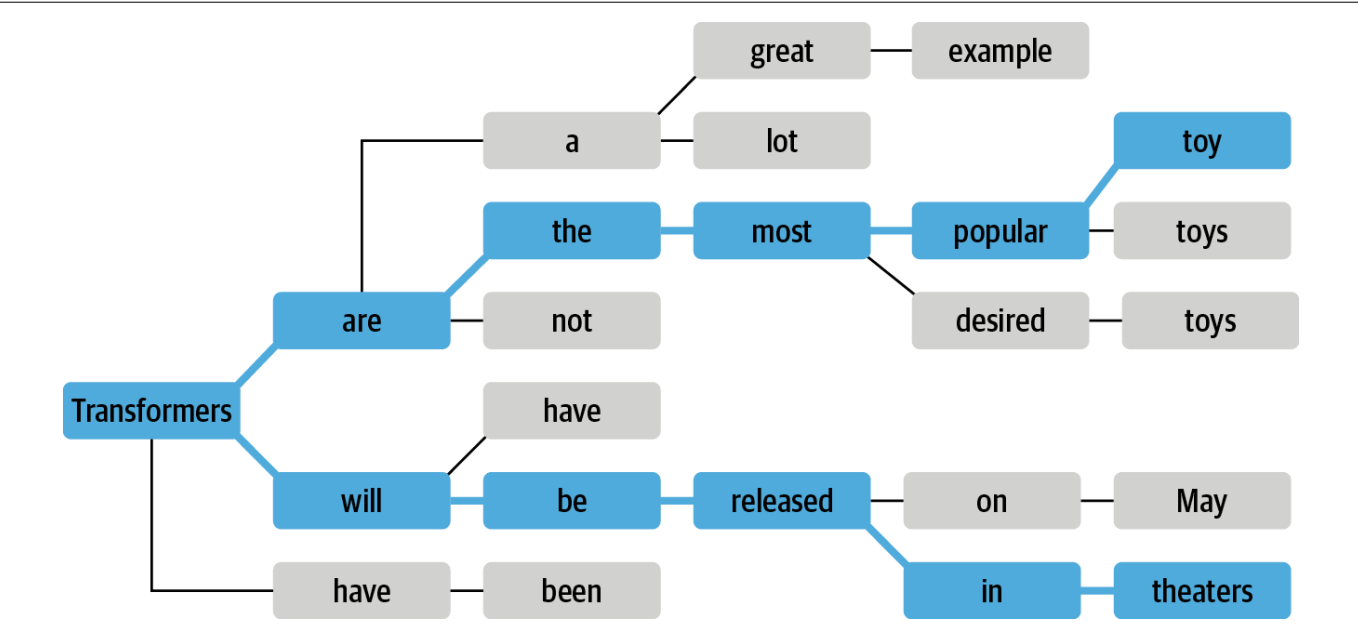

In [24]:
Image('../imgs/beam-search-2.png', width=600)

- `model.generate()`
    - 默认 greedy search，`num_beams` 不设置的话
    - `do_sample=False`
    - `max_length`: prompt + generation 的总长度
    - `max_new_tokens`: generation 的长度
    - 对于 beam search
        - `num_beams=5`
    - 控制重复性：`no_repeat_ngram_size=2`
        - tracks which n-grams have been seen
and sets the next token probability to zero if it would produce a previously seen
n-gram:

$$
\begin{split}
\log P(\textbf{y}|\textbf{x})&=\log P(y_1,y_2,\cdots,y_t|\textbf{x})\\
&=\log\Pi_{t=1}^Np(y_t|y_{\lt t}, \textbf{x})\quad (y_{\lt t}=y_{1,2,\cdots,t-1})\\
&=\sum_{i=1}^N\log p(y_{t}|y_{\lt t}, \textbf x)
\end{split}
$$

In [25]:
0.5**1024

5.562684646268003e-309

In [26]:
1024*torch.log(torch.tensor(0.5))

tensor(-709.7827)

In [27]:
def log_probs_from_logits(logits, labels):
    # (b, s, h), h == 50257
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label
def sequence_logprob(model, labels, prompt_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, prompt_len:])
    return seq_log_prob.cpu().numpy()

In [30]:
print(len(input_ids[0]))
print(output_greedy.shape)

45
torch.Size([1, 128])


In [31]:
logp = sequence_logprob(model, output_greedy, prompt_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
logp

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.

The researchers were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.

The researchers were conducting a study on the Andean


array(-68.73988, dtype=float32)

In [32]:
output_beam = model.generate(input_ids, max_length=128, num_beams=5, do_sample=False)
logp = sequence_logprob(model, output_beam, prompt_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
logp

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The discovery of the unicorns was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.

According to the researchers, the unicorns were found in a remote valley in the Andes Mountains. The valley is known as the "Valley of the Unicorns" because of the number of unicorns that have been found there.

The valley


array(-72.29845, dtype=float32)

In [33]:
output_beam = model.generate(input_ids, max_length=128, num_beams=5, do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, prompt_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
logp

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The discovery was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society. The team, led by Dr. David Hone, discovered the unicorn herd while conducting a study on the ecology and evolution of mountain goats. According to a press release, the team found the herd in an area that had never been explored before. They were able to track the animals using


array(-106.28981, dtype=float32)